# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Общая информация. 

In [1]:
import pandas as pd
df = pd.read_csv("/datasets/real_estate_data.csv", sep='\t', decimal='.')
print(df.head(10))
print(df.info())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0      108.00  2019-03-07T00:00:00      3   
1             7   3350000.0       40.40  2018-12-04T00:00:00      1   
2            10   5196000.0       56.00  2015-08-20T00:00:00      2   
3             0  64900000.0      159.00  2015-07-24T00:00:00      3   
4             2  10000000.0      100.00  2018-06-19T00:00:00      2   
5            10   2890000.0       30.40  2018-09-10T00:00:00      1   
6             6   3700000.0       37.30  2017-11-02T00:00:00      1   
7             5   7915000.0       71.60  2019-04-18T00:00:00      2   
8            20   2900000.0       33.16  2018-05-23T00:00:00      1   
9            18   5400000.0       61.00  2017-02-26T00:00:00      3   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0        51.00      8          NaN  ...   
1             NaN          11.0        18.60      1          NaN  ...   

### Вывод

Мы рассмотрели таблицу. В ней 23699 строк и 22 столбца. Подробнее по столбцам:
last_price - нужно перевести в int +
total_area - во float или int +
first_day_exposition - перевести в нормальный формат времени +
ceiling_height - во float и дополнить недостающие данные  *
floors_total - в int и пополнить недостающие данные +
living_area - в float и дополнить
is_apartment - перевести в булевые данные
kitchen_area - перевести во float и дполнить данные
balcony - перевести в int дполнить данные
locality_name - посомтреть на пропуски дполнить данные +
airports_nearest - дполнить данные, перевест ив int
cityCenters_nearest - дполнить данные, перевести в int
parks_around3000 - перевести в int, дополнить данные
parks_nearest - перевести в int, дополнить данные
ponds_nearest - перевести в int, дополнить данные
days_exposition - перевести в int, дополнить данные

Чем заменять и заменять ли данные в описанных столбцах будем сомтреть по ходу.

<div style="border:solid green 2px; padding: 20px">

<h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Хорошее начало, так держать!)

</div>

### Шаг 2. Предобработка данных

In [2]:
# столбик last price
df['last_price'] = pd.to_numeric(df['last_price'], errors='coerce') # переводим в цифры
df['last_price'] = df['last_price'].astype('int') #переводим в инт
print(df[df['last_price'].isnull()]) # проверяем на наличие Nan 
#df.info() # проверяем что все нормально

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition]
Index: []

[0 rows x 22 columns]


In [3]:
#столбик total_area
df['total_area'] = pd.to_numeric(df['total_area']) #переводим во float
# df.info()
#print(df['total_area'].head(20))
# все хорошо

In [4]:
# столбик first_day_exposition
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format = "%Y-%m-%dT%H:%M:%S" )
print(df['first_day_exposition'].head())
#df.info() все хорошо

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]


In [5]:
# столбик locality_name часть 1
# мы видим что в нем отсутствует около 50 значений
#print(df[df['locality_name'].isnull()])
# поскольку их совсем немного, а их наличие играет критическое значение проще просто удалить их
df = df.loc[df['locality_name'].notnull()]
print(df[df['locality_name'].isnull()])
df.reset_index(inplace = True)
#print(df.info())  удалили 50 пустых значений

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition]
Index: []

[0 rows x 22 columns]


In [6]:
# столбик locality_name

locals_table = df['locality_name'].value_counts()
#print(locals_table)
#print(locals_table.hist(bins = 50, range=(0, 360))) # посмотрим как много заявлений из маленьких населенных пунктов
# мы видим что 250 из 364 населенных пунктов имеют меньше 5 объявлений, возможно потом их следует объеденить
local_ids = {} # дадим каждому насленному пункту свой номер и создадим словарик
number = 0
for i in locals_table:
    local_ids[number] = locals_table.index[number]
    number = number + 1
    
local_ids = {v:k for k, v in local_ids.items()} # меняем местами ключ-значение что бы работало
#print(local_ids)
def addid(id):
    return local_ids.get(id)

df['local_ids'] = df['locality_name'].apply(addid) # добавляем столбик local_ids с номером локации

#print(df.head()) 
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 24 columns):
index                   23650 non-null int64
total_images            23650 non-null int64
last_price              23650 non-null int64
total_area              23650 non-null float64
first_day_exposition    23650 non-null datetime64[ns]
rooms                   23650 non-null int64
ceiling_height          14490 non-null float64
floors_total            23565 non-null float64
living_area             21752 non-null float64
floor                   23650 non-null int64
is_apartment            2760 non-null object
studio                  23650 non-null bool
open_plan               23650 non-null bool
kitchen_area            21381 non-null float64
balcony                 12137 non-null float64
locality_name           23650 non-null object
airports_nearest        18116 non-null float64
cityCenters_nearest     18139 non-null float64
parks_around3000        18140 non-null float64
parks_near

In [7]:
#столбик floors_total 23565 non-null object
#print(df[df['floors_total'].isnull()].tail(10))

df['floors_total'] = df['floors_total'].fillna(value='') # заменим Na
known_floors = df.query('floors_total !=""  ')# сохраним отдельно только строки где количество этажей в доме известно
#df.info()
#known_floors.info()

In [8]:
# поскольу речь идет о домах, мы можем дополнить значения количества этажей попробывав найти другое обьявление в этом же доме.
#дом мы считаем тем же если он находится в том же насленном пункте в таком-же количестве метров от центр
#counter = 0
#df.info() #ceiling_height   14490 non-null float64
def floor_finder(row):
    
    to_center = row['cityCenters_nearest']
    local_id = row['local_ids']
    floor = row['floors_total']
    if (floor == "")&(to_center in known_floors['cityCenters_nearest']) :
        results = known_floors.query('(cityCenters_nearest == @to_center)&(local_ids == @local_id)')
        results.reset_index(inplace = True)
        if results.size > 0:
                #global counter
                #counter = counter + 1
                #print(counter)
                #print(results['floors_total'].mode()[0])
                return results['floors_total'].mode()[0] # используем моду если там несколько домов окажется
        else:
            return floor
    else:
        return floor      
df['floors_total'] = df.apply(floor_finder, axis=1) # находим этажи

# таким методом мы нашли этажи в 52 недостающих домах.
# в оставшихся случаях заменим на медианное значение этажности в данном насленном пункте
# df.info() 23650 obj
def floor_finder_median(row):
    floor = row['floors_total']
    local_id = row['local_ids']
    #print(floor)
    if floor == '':
        results = known_floors.query('local_ids == @local_id')
        #print(results['floors_total'].median())
        return results['floors_total'].median()
        
    else:
        return floor
df['floors_total'] = df.apply(floor_finder_median, axis=1)
#первеведем формат
df['floors_total'] = pd.to_numeric(df['floors_total'], errors='coerce') 
df['floors_total'] = df['floors_total'].astype('int')

In [9]:
# займемся столбцом living_area
#df.info() #living_area 21752 non-null float64
#print(df.query('(total_area.notnull())&(living_area.isnull())&(kitchen_area.notnull())'))  # 438 таких строк
# для начала найдем living_area для тех квартир где известна общая площадь и площадь кухни
df['living_area']= df['living_area'].fillna('')

def living_area_finder(row):
    kitchen = row['kitchen_area']
    living = row['living_area']
    total = row['total_area']
    if living == '' :
        #print('Подставляем значение')
        return total - kitchen
    else:
        return living
df['living_area'] = df.apply(living_area_finder, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 24 columns):
index                   23650 non-null int64
total_images            23650 non-null int64
last_price              23650 non-null int64
total_area              23650 non-null float64
first_day_exposition    23650 non-null datetime64[ns]
rooms                   23650 non-null int64
ceiling_height          14490 non-null float64
floors_total            23650 non-null int64
living_area             22190 non-null float64
floor                   23650 non-null int64
is_apartment            2760 non-null object
studio                  23650 non-null bool
open_plan               23650 non-null bool
kitchen_area            21381 non-null float64
balcony                 12137 non-null float64
locality_name           23650 non-null object
airports_nearest        18116 non-null float64
cityCenters_nearest     18139 non-null float64
parks_around3000        18140 non-null float64
parks_neares

In [10]:
# Оставшиеся не найденные 1460 значения лучше всего заменить на средне значение по количеству комнат в квартире
df['living_area']= df['living_area'].fillna('')
known_living_area = df.query('living_area != ""')

def find_living_area(row):
    living_area = row['living_area']
    rooms = row['rooms']
    if living_area == '':
        findit = known_living_area[['rooms', 'living_area']].query('rooms == @rooms').mean()
        findit.reset_index()
        #print('подставляем значение',findit[1] )
        return findit[1]
    else:
        return living_area
    
df['living_area'] = df.apply(find_living_area, axis=1)

df.info() # living_area 23650 non-null float64 отлично!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 24 columns):
index                   23650 non-null int64
total_images            23650 non-null int64
last_price              23650 non-null int64
total_area              23650 non-null float64
first_day_exposition    23650 non-null datetime64[ns]
rooms                   23650 non-null int64
ceiling_height          14490 non-null float64
floors_total            23650 non-null int64
living_area             23650 non-null float64
floor                   23650 non-null int64
is_apartment            2760 non-null object
studio                  23650 non-null bool
open_plan               23650 non-null bool
kitchen_area            21381 non-null float64
balcony                 12137 non-null float64
locality_name           23650 non-null object
airports_nearest        18116 non-null float64
cityCenters_nearest     18139 non-null float64
parks_around3000        18140 non-null float64
parks_neares

In [11]:
# столбик ceiling_height. высота потолков поступим так же как с количеством этажей. 
#(мы исходим из того что выоста потолков во всем доме одинаковая) 
#попробуем найти этот дом по расстоянию до центра и подставить известно значение выоты потолков
df['ceiling_height']= df['ceiling_height'].fillna('')
known_celgihgh = df.query('ceiling_height != ""')
#counter = 0
def celhig_finder(row):
    
    to_center = row['cityCenters_nearest']
    local_id = row['local_ids']
    celgihgh = row['ceiling_height']
    if (celgihgh == "")&(to_center in known_celgihgh['cityCenters_nearest']) :
        results = known_celgihgh.query('(cityCenters_nearest == @to_center)&(local_ids == @local_id)')
        results.reset_index(inplace = True)
        if results.size > 0:
                #print(results['floors_total'].mode()[0])
                #global counter
                #counter = counter + 1    # 2493 значения мы заменили
                #print(counter)
                return results['ceiling_height'].mode()[0] # используем моду если там несколько домов окажется
        else:
            return celgihgh
    else:
        return celgihgh      
df['ceiling_height'] = df.apply(celhig_finder, axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 24 columns):
index                   23650 non-null int64
total_images            23650 non-null int64
last_price              23650 non-null int64
total_area              23650 non-null float64
first_day_exposition    23650 non-null datetime64[ns]
rooms                   23650 non-null int64
ceiling_height          23650 non-null object
floors_total            23650 non-null int64
living_area             23650 non-null float64
floor                   23650 non-null int64
is_apartment            2760 non-null object
studio                  23650 non-null bool
open_plan               23650 non-null bool
kitchen_area            21381 non-null float64
balcony                 12137 non-null float64
locality_name           23650 non-null object
airports_nearest        18116 non-null float64
cityCenters_nearest     18139 non-null float64
parks_around3000        18140 non-null float64
parks_nearest

In [12]:
df['ceiling_height'] = pd.to_numeric(df['ceiling_height'], errors='coerce') 
df.info() # 16983 известных высоты потолка. остальные оставим неизвестными

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 24 columns):
index                   23650 non-null int64
total_images            23650 non-null int64
last_price              23650 non-null int64
total_area              23650 non-null float64
first_day_exposition    23650 non-null datetime64[ns]
rooms                   23650 non-null int64
ceiling_height          16983 non-null float64
floors_total            23650 non-null int64
living_area             23650 non-null float64
floor                   23650 non-null int64
is_apartment            2760 non-null object
studio                  23650 non-null bool
open_plan               23650 non-null bool
kitchen_area            21381 non-null float64
balcony                 12137 non-null float64
locality_name           23650 non-null object
airports_nearest        18116 non-null float64
cityCenters_nearest     18139 non-null float64
parks_around3000        18140 non-null float64
parks_neares

In [13]:
# is_apartment переведем в булевое значение
#print(df.query('is_apartment == False'))
#print(df.query('is_apartment == True'))
# Мы поняли что там 2710 False, 50 True остальное наны. оставим пока как есть.


In [14]:
# рассмотрим parks_around300 и parks_nearest
#print(df['parks_around3000'].value_counts())
#print(df['parks_nearest'].hist(bins = 50))
#print(df.query('(parks_around3000.isnull())&(parks_nearest>0)'))

df['parks_nearest'] = df['parks_nearest'].fillna("")
good_parks_nearest =df.query('parks_nearest !=""')
# там где есть парк в 3км, но нет точного расстояния до парка поставим медианное растоние
def park_finder_median(row):
    park3 = row['parks_around3000']
    parknear = row['parks_nearest']
    if ((parknear == '')&(park3 !='nan')):
        results = good_parks_nearest.query('parks_around3000 == @park3')
        #print(park3)
        #print(results['parks_nearest'].median())
        return results['parks_nearest'].median()       
    else:
        return parknear
   
df['parks_nearest'] = df.apply(park_finder_median, axis=1)
#первеведем формат
df['parks_nearest'] = pd.to_numeric(df['parks_nearest'], errors='coerce') 

df.info() #parks_around3000 18140 non-null float64 столько же сколько parks_nearest


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 24 columns):
index                   23650 non-null int64
total_images            23650 non-null int64
last_price              23650 non-null int64
total_area              23650 non-null float64
first_day_exposition    23650 non-null datetime64[ns]
rooms                   23650 non-null int64
ceiling_height          16983 non-null float64
floors_total            23650 non-null int64
living_area             23650 non-null float64
floor                   23650 non-null int64
is_apartment            2760 non-null object
studio                  23650 non-null bool
open_plan               23650 non-null bool
kitchen_area            21381 non-null float64
balcony                 12137 non-null float64
locality_name           23650 non-null object
airports_nearest        18116 non-null float64
cityCenters_nearest     18139 non-null float64
parks_around3000        18140 non-null float64
parks_neares

In [15]:
#Другие столбики

#столбик days_exposition. в нем есть пропуски, это видимо те обьявления которые на момент выгрузки данных не были закрыты
#с прудами все тоже самое что и с парками не получится. там везде где 0 значение прудов в 3км, Наны в прудах рядом.
# просто переведем их в другой формат и оставим с пропусками
# is_appartment 50 ture 250 false остальные неизвестны. лучше так и оставить.

### Выводы: 
Мы рассмотрели таблицу. Удалили небольшео количество строк без адреса. Доплнили показатели высоты потолков и количества этажей в доме поиском других обьявлений по данному дому.
Дополнили медианными значениями некотоыре пропуски. Нашли ближайшие пруды и парки там гже это было возможно. Доплнили таблицу индексами городов. Привели значение столбиков к float/int и занчение столбика времени к временному формату.

### Шаг 3. Посчитайте и добавьте в таблицу

In [16]:

#цена квадратного метра

df['meter_price']= df['last_price']/df['total_area']
df.info() # сделано

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 25 columns):
index                   23650 non-null int64
total_images            23650 non-null int64
last_price              23650 non-null int64
total_area              23650 non-null float64
first_day_exposition    23650 non-null datetime64[ns]
rooms                   23650 non-null int64
ceiling_height          16983 non-null float64
floors_total            23650 non-null int64
living_area             23650 non-null float64
floor                   23650 non-null int64
is_apartment            2760 non-null object
studio                  23650 non-null bool
open_plan               23650 non-null bool
kitchen_area            21381 non-null float64
balcony                 12137 non-null float64
locality_name           23650 non-null object
airports_nearest        18116 non-null float64
cityCenters_nearest     18139 non-null float64
parks_around3000        18140 non-null float64
parks_neares

In [17]:
#этаж квартиры; варианты — первый, последний, другой;

def floorchecker(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor ==1:
        return 'первый'
    if floor == floors_total:
        return 'последний'
    else:
        return 'другой'

    
df['floor_type'] = df.apply(floorchecker, axis=1)
print(df['floor_type'].value_counts()) # норм

другой       17403
последний     3335
первый        2912
Name: floor_type, dtype: int64


In [18]:
#соотношение жилой и общей площади, а также отношение площади кухни к общей.



df['living_to_total']=df['living_area']/df['total_area']
df['kitchen_to_total']=df['kitchen_area']/df['total_area']

print(df['living_to_total'].head())
print(df['kitchen_to_total'].head())

0    0.472222
1    0.460396
2    0.612500
3    0.301876
4    0.320000
Name: living_to_total, dtype: float64
0    0.231481
1    0.272277
2    0.148214
3         NaN
4    0.410000
Name: kitchen_to_total, dtype: float64


In [19]:
#день недели, месяц и год публикации объявления;
df['weekday']=df['first_day_exposition'].dt.day_name()
df['month']=df['first_day_exposition'].dt.month_name()
df['year'] = df['first_day_exposition'].dt.year
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 31 columns):
index                   23650 non-null int64
total_images            23650 non-null int64
last_price              23650 non-null int64
total_area              23650 non-null float64
first_day_exposition    23650 non-null datetime64[ns]
rooms                   23650 non-null int64
ceiling_height          16983 non-null float64
floors_total            23650 non-null int64
living_area             23650 non-null float64
floor                   23650 non-null int64
is_apartment            2760 non-null object
studio                  23650 non-null bool
open_plan               23650 non-null bool
kitchen_area            21381 non-null float64
balcony                 12137 non-null float64
locality_name           23650 non-null object
airports_nearest        18116 non-null float64
cityCenters_nearest     18139 non-null float64
parks_around3000        18140 non-null float64
parks_neares

Вывод:
мы добавили столбики с ценой квадратного метра, соотношения жилой площади к общей и площади кухни к общей площади, сделали отдельные столбики с днем недели, годом и месяцем обьявления, обозначили первый последний и другие этажи обьявлений.

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

In [20]:
#площадь

#print(df['total_area'].hist(bins = 100 ))
#похоже на распределение Пуассона, можно рассмотреть отдельно исключенияб ольше 250
print(df['meter_price'].mean())
#print(df[df['total_area'] > 250]) #их всего 112
print(df[df['total_area'] > 250]['meter_price'].mean()) # странно что для больших помещений метр стоит в два раза больше
# можно убрать исключения что бы не портили гистаграмму, т.к их всего 112
df = df.query('total_area < 250')
print(df['total_area'].hist(bins = 10 )) # так лучше

99432.24715198246
224602.0404982911
AxesSubplot(0.125,0.11;0.775x0.77)


6187722.550352681
4600000.0
AxesSubplot(0.125,0.125;0.775x0.755)
       index  total_images  last_price  total_area first_day_exposition  \
3          3             0    64900000       159.0           2015-07-24   
492      492            18    95000000       216.0           2017-12-05   
509      509             5    90000000       225.0           2016-06-26   
1435    1436            19   330000000       190.0           2018-04-04   
1705    1706            10    62171920       200.3           2018-05-19   
...      ...           ...         ...         ...                  ...   
22663  22709            20    59000000       127.5           2016-12-21   
22757  22804             4    81960000       205.0           2017-09-29   
22784  22831            18   289238400       187.5           2019-03-19   
22860  22907             9    65000000       228.0           2016-06-02   
23525  23574            14    64990000       139.0           2015-11-24   

       rooms  ceiling_height  floo

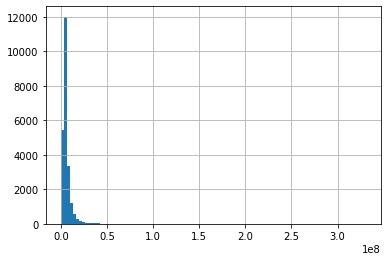

In [21]:
# цена
print(df['last_price'].mean())
print(df['last_price'].median()) # медиана существенно меньше
print(df['last_price'].hist(bins = 100)) #странно получается длинный хвост хотя тут распредление должно походить на нормальное
#изучим хвост
tail = df.query('last_price > 50000000')
print(tail)
#print(tail['last_price'].hist(bins=10))
#их всего 75, но это может быть премиум сегмент, не факт что его стоит удалять

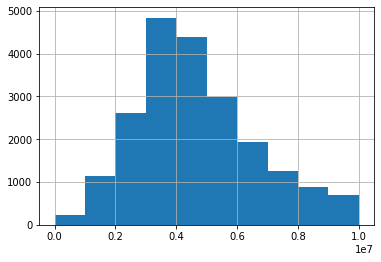

In [22]:
#сделаем что бы была гистаграмма с нормальным распределением по цене. Хвост дорогих квартир обрезать не будем
df['last_price'].hist(bins = 10, range=(0, 10000000))
#похоже на правду!

       index  total_images  last_price  total_area first_day_exposition  \
144      144             1     2450000       27.00           2017-03-30   
349      349             4     2320000       25.00           2017-09-27   
440      440             8     2480000       27.11           2018-03-12   
508      508             0     3375000       34.40           2017-03-28   
608      608             2     1850000       25.00           2019-02-20   
...      ...           ...         ...         ...                  ...   
23162  23210             7     3200000       26.00           2017-09-01   
23393  23442             0     2500000       27.70           2017-09-28   
23505  23554            15     3350000       26.00           2018-09-07   
23543  23592            10     1450000       29.00           2017-11-11   
23588  23637             8     2350000       26.00           2018-06-26   

       rooms  ceiling_height  floors_total  living_area  floor  ...  \
144        0             NaN

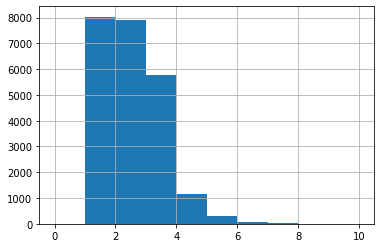

In [23]:
# число комнат
#df['rooms'].hist(bins=10, range = (0,10)) #похоже на правду, но странно когда меньше 1 комнаты, рассмотрим это
print(df.query('rooms < 1')) # это какие-то странные 196 значения, лучше от них избавиться
df=df.query('rooms >= 1')
df['rooms'].hist(bins=10, range = (0,10))

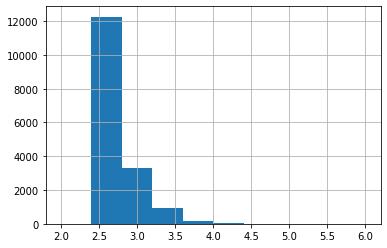

In [24]:
#высота потолков

#df['ceiling_height'].hist()#какие то неправильные значения есть бльше 10 метров
#print(df.query('ceiling_height > 10')) #всего 27 значений, удаляем
#print(df.query('ceiling_height < 2')) #3 ошибочных значения
df = (df.query('(ceiling_height < 10)&(ceiling_height > 2)'))

df['ceiling_height'].hist(bins = 10, range =(2, 6)) #так похоже на правду

101.0
187.46153846153845


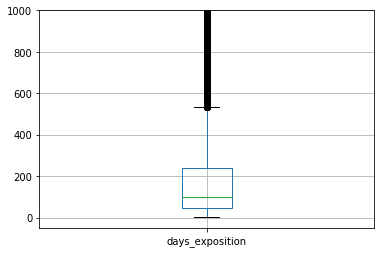

In [25]:
#Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану.
#Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли 
#очень быстро, а когда необычно долго?
import matplotlib.pyplot as plt

df.boxplot('days_exposition')
plt.ylim(-50, 1000)

#df['days_exposition'].hist()
print(df['days_exposition'].median())
print(df['days_exposition'].mean())
#необычно долго - когда более 500 дней.
#в среднем продажа занимает около 180 дней. (номрально от 50 до 220 дней)
#если очень повезет то квартира продается меньше 50дней


102651.97041580091
150330.31647046586
117429.76080166727


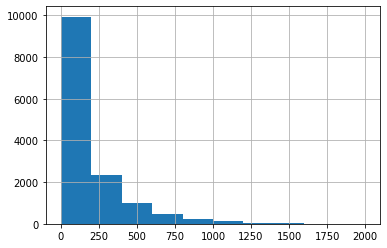

In [26]:
#Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили.
#df['days_exposition'].hist(bins = 10, range=(0, 10))
df['days_exposition'].hist(bins = 10, range=(0, 2000))

#к редким и выдающимся можно отнести небольшое количество объявлений висящи меньше 3 дней
#и более 1200 дней

extrafast = df.query('days_exposition <= 3')
extralong = df.query('days_exposition > 1200')
print(df['meter_price'].mean())
print(extrafast['meter_price'].mean()) # при этом у таких обьявлений цена в среднем выше. Хотя их всего 4шт
print(extralong['meter_price'].mean()) #а те кто долго не могут продать видимо со временем снижжают цену

df= df.loc[(df['days_exposition'] >3)&(df['days_exposition']<1200)]

In [27]:
#Какие факторы больше всего влияют на стоимость квартиры? 
#Изучите, зависит ли цена от квадратного метра, числа комнат, удалённости от центра. 
#Изучите зависимость цены от того, на каком этаже расположена 
#квартира: первом, последнем или другом. Также изучите зависимость от даты 
#    размещения: дня недели, месяца и года.

print(df.corr())
# на стоимость квартиры больше всег овлияет ее площадь, количество комнат, высота потолков. 
#Меньше расстояние до центра города. 
#Еще немного влияет близость к паркам. Так же стоимость корелирует с количеством фото.


print(df.query('floor_type == "первый"')['meter_price'].mean())
print(df.query('floor_type == "последний"')['meter_price'].mean())
print(df.query('floor_type == "другой"')['meter_price'].mean())
# на первом этаже самые дешевые квартиры, на последнем чуть дороже, а самые дорогие на других этажах


                        index  total_images  last_price  total_area     rooms  \
index                1.000000      0.004974   -0.005899   -0.003956 -0.007591   
total_images         0.004974      1.000000    0.116269    0.103955  0.077874   
last_price          -0.005899      0.116269    1.000000    0.664344  0.394479   
total_area          -0.003956      0.103955    0.664344    1.000000  0.788719   
rooms               -0.007591      0.077874    0.394479    0.788719  1.000000   
ceiling_height      -0.012884      0.033371    0.389763    0.436801  0.239697   
floors_total        -0.007149      0.006039    0.013201   -0.047057 -0.216016   
living_area         -0.004191      0.078896    0.552990    0.916544  0.862959   
floor                0.000277      0.025690    0.032199   -0.020038 -0.158625   
studio              -0.000448     -0.012696   -0.010620   -0.024139 -0.023486   
open_plan            0.001101     -0.009109   -0.001611    0.001838  0.010304   
kitchen_area         0.00334

             meter_price
month                   
April      103096.055704
August     102343.535223
December   101896.373756
February   100336.987417
January    102054.281028
July       101591.093156
June        98135.358557
March       98166.380395
May        101120.787102
November   100627.114481
October    100151.019973
September  102956.085795
             meter_price
weekday                 
Friday     100590.813906
Monday     100061.315977
Saturday    99788.980287
Sunday     100337.259354
Thursday   101970.798042
Tuesday    101585.233653
Wednesday  100976.192170
AxesSubplot(0.125,0.125;0.775x0.755)


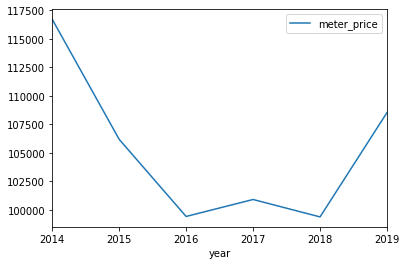

In [28]:
#зависимость от даты

print(pd.pivot_table(data = df, index = 'month', values = 'meter_price', aggfunc = 'mean'))
# дешевле всего в июне и марте, дороже всего в апреле и сентябре. Хотя разброс не большой и скорее случайный
print(pd.pivot_table(data = df, index = 'weekday', values = 'meter_price', aggfunc = 'mean' ))
# по субботам у людей хорошее настроение и они ставят цену чуть ниже обычного
print(pd.pivot_table(data = df, index = 'year', values = 'meter_price', aggfunc = 'mean' ).plot())
#график покажет как менялась цена по годам, дороже всего было в 2014


In [29]:
#Выберите 10 населённых пунктов с наибольшим числом объявлений. 

#df['locality_name'].sort_values
top10 = df.groupby('locality_name').count().sort_values('index', ascending = False).head(10) 
citynames = []
#print(top10)
number = 0
for i in range(0,10):
    citynames.append(top10.index[number])
    number = number+1
print(citynames) #топ 10 городов

dftop10 = df.query('locality_name in @citynames')

print(dftop10.groupby('locality_name').count().sort_values('index', ascending = False)) # проверяем



['Санкт-Петербург', 'посёлок Шушары', 'Всеволожск', 'посёлок Парголово', 'посёлок Мурино', 'Пушкин', 'Колпино', 'Гатчина', 'Петергоф', 'деревня Кудрово']
                   index  total_images  last_price  total_area  \
locality_name                                                    
Санкт-Петербург    10380         10380       10380       10380   
посёлок Шушары       221           221         221         221   
Всеволожск           218           218         218         218   
посёлок Парголово    216           216         216         216   
посёлок Мурино       195           195         195         195   
Пушкин               186           186         186         186   
Колпино              179           179         179         179   
Гатчина              125           125         125         125   
Петергоф             125           125         125         125   
деревня Кудрово      118           118         118         118   

                   first_day_exposition  rooms  ceili

In [30]:
#Посчитайте среднюю цену квадратного метра в этих населённых пунктах. 
#Выделите населённые пункты с самой высокой и низкой стоимостью жилья. 

print(pd.pivot_table(data =dftop10, index = 'locality_name', values = 'meter_price', aggfunc = 'mean'))
#мы видим что самое дорогое жилье в Петербурге и Пушкине, самое дешевое во Всеволожске и Гатчине.

                     meter_price
locality_name                   
Всеволожск          66508.579495
Гатчина             69179.960817
Колпино             75062.589531
Петергоф            83748.540811
Пушкин             102024.184893
Санкт-Петербург    111952.131750
деревня Кудрово     90567.907948
посёлок Мурино      87333.687602
посёлок Парголово   91405.434944
посёлок Шушары      78740.079003


AxesSubplot(0.125,0.125;0.775x0.755)
     index  total_images  last_price  total_area first_day_exposition  rooms  \
748    748            13    14350000        74.0           2017-11-28      2   

     ceiling_height  floors_total  living_area  floor  ... days_exposition  \
748            3.13             5         30.0      3  ...           128.0   

     local_ids    meter_price  floor_type  living_to_total kitchen_to_total  \
748          0  193918.918919      другой         0.405405         0.337838   

     weekday     month  year  km  
748  Tuesday  November  2017  27  

[1 rows x 32 columns]
       index  total_images  last_price  total_area first_day_exposition  \
61        61            18     7990000        74.0           2017-08-24   
63        63             2    20000000       118.0           2018-09-11   
121      121            20    33000000       180.0           2017-02-17   
136      136            16     6500000        51.8           2018-08-01   
137      137      

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


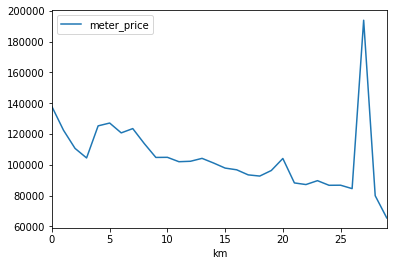

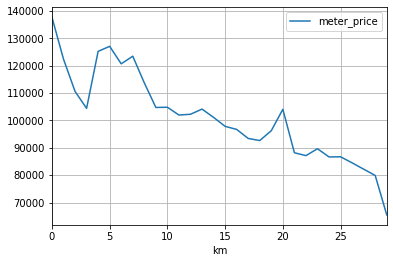

In [31]:
#Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра.
#Выделите квартиры в Санкт-Петербурге ('locality_name'). 
peterdf = df.loc[df['locality_name'] == "Санкт-Петербург"] 
#Ваша задача — выяснить, какая область входит в центр. 
#Создайте столбец с расстоянием до центра в километрах: округлите до целых значений.
peterdf['km']=peterdf['cityCenters_nearest']/1000
#уберем пропуски (мы уже заполнили что могли ранее)
peterdf['km'] = peterdf['km'].fillna(value='')
peterdf = peterdf.query('km != ""') # переводим в цифры
peterdf['km'] = peterdf['km'].astype('int')

#После этого посчитайте среднюю цену для каждого километра. 
#Постройте график: он должен показывать, как цена зависит от удалённости от центра. 
#Определите границу, где график сильно меняется — это и будет центральная зона.

print(pd.pivot_table(data = peterdf, index = 'km', values = 'meter_price', aggfunc = 'median' ).plot())

# странное искревление после 25км и непонятная горка вниз у 2.5км посомтрим их подробнее
#peterdf.info()
print(peterdf.query('(km>25)&(km < 40)&(meter_price > 140000)')) #  видимо из-за небольшого количества домов в таком отдолении, этот один все портит
peterdf = peterdf.drop([748]) # уберем его
#peterdf.info()
print(peterdf.query('(km>2)&(km <5)&(meter_price > 100000)')) # а впадина около 2.5км естественная.
print(pd.pivot_table(data = peterdf, index = 'km', values = 'meter_price', aggfunc = 'median' ).plot(grid=True))

#так лучше. Мы видим что цена метра постепенно падает до 2.5км, 
#затем поднимается и снова идет на резкий спад после 7км.
# впадина в центре это судя по всему квартиры около вокзалов, где не очень приятно жить. Оба вокзала
#по яндекскартам находятся в 2.5км от центра

# Таким образом за центр принимаем значение 3км.

In [32]:
#Выделите сегмент квартир в центре. 
peterdfcenter = peterdf.query('km <=3')
#Проанализируйте эту территорию и изучите следующие параметры: 
#площадь, цена, число комнат, высота потолков. 
print(peterdfcenter.mean())
print(peterdf.mean())
#плоащь квартир тут примерно на 30% больше чем в целом по Питеру
#стоимость тут в среднем 13.5миллионов против 7.2миллионов по всему городу
#в среднем в центре 3 комнаты, а не 2.1
#и потолки в историческом центре на 47см выше

#Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). 
peterdfcenter.corr()
#peterdf.corr()
#Число комнат кореляция с ценой 0.4 по Питеру, 0.25по центру. В центре количество комнат менее значимо

index                  1.162746e+04
total_images           1.026528e+01
last_price             1.353706e+07
total_area             9.163855e+01
rooms                  3.016393e+00
ceiling_height         3.173949e+00
floors_total           5.157973e+00
living_area            5.601374e+01
floor                  3.214605e+00
is_apartment           4.081633e-02
studio                 0.000000e+00
open_plan              1.490313e-03
kitchen_area           1.382293e+01
balcony                3.801653e-01
airports_nearest       2.258461e+04
cityCenters_nearest    2.600198e+03
parks_around3000       1.311475e+00
parks_nearest          1.185940e+03
ponds_around3000       1.792846e+00
ponds_nearest          3.785871e+02
days_exposition        2.454694e+02
local_ids              0.000000e+00
meter_price            1.374150e+05
living_to_total        6.051763e-01
kitchen_to_total       1.612466e-01
year                   2.017036e+03
km                     2.093890e+00
dtype: float64
index        

,index,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,local_ids,meter_price,living_to_total,kitchen_to_total,year,km
index,1.000000,0.004259,-0.058642,-0.011399,-0.007467,0.004525,-0.022050,0.015422,-0.016457,NaN,...,0.045846,0.034011,-0.023404,0.013520,NaN,-0.070259,0.032643,-0.013191,0.026432,-0.005019
total_images,0.004259,1.000000,0.174600,0.151631,0.068208,0.063811,0.004214,0.093801,0.052412,NaN,...,-0.067970,0.002114,-0.011775,-0.044045,NaN,0.152506,-0.117483,0.068534,0.137026,0.005796
last_price,-0.058642,0.174600,1.000000,0.532215,0.249107,0.139548,0.189228,0.410397,0.152343,NaN,...,-0.105098,0.073652,-0.085600,0.048506,NaN,0.891801,-0.085072,-0.048132,-0.073799,-0.143558
total_area,-0.011399,0.151631,0.532215,1.000000,0.782918,0.199018,0.132386,0.937930,0.132693,NaN,...,-0.063308,0.026998,-0.017184,0.163413,NaN,0.212341,0.124951,-0.305395,-0.151622,-0.093867
rooms,-0.007467,0.068208,0.249107,0.782918,1.000000,0.097851,-0.024444,0.839230,0.031693,NaN,...,-0.049241,-0.025446,-0.022942,0.161857,NaN,-0.028959,0.391416,-0.449880,-0.083030,-0.066752
ceiling_height,0.004525,0.063811,0.139548,0.199018,0.097851,1.000000,-0.103122,0.182363,-0.051425,NaN,...,-0.068228,0.033191,0.012196,0.052116,NaN,0.097232,-0.013455,-0.002931,-0.047229,-0.080470
floors_total,-0.022050,0.004214,0.189228,0.132386,-0.024444,-0.103122,1.000000,0.064251,0.424137,NaN,...,0.043257,-0.139628,-0.025507,0.060695,NaN,0.183232,-0.170251,0.038283,-0.138691,0.200119
living_area,0.015422,0.093801,0.410397,0.937930,0.839230,0.182363,0.064251,1.000000,0.111895,NaN,...,-0.052159,0.018152,-0.008751,0.160193,NaN,0.105021,0.429656,-0.468122,-0.124356,-0.085730
floor,-0.016457,0.052412,0.152343,0.132693,0.031693,-0.051425,0.424137,0.111895,1.000000,NaN,...,0.012157,-0.092701,-0.020033,0.043860,NaN,0.123313,-0.017207,-0.051483,-0.034343,0.115913
studio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
#этаж удалённость от центра, дата размещения объявления
#этаж

print(peterdfcenter.query('floor_type == "первый"')['meter_price'].mean())
print(peterdfcenter.query('floor_type == "последний"')['meter_price'].mean())
print(peterdfcenter.query('floor_type == "другой"')['meter_price'].mean())
print()
print(peterdf.query('floor_type == "первый"')['meter_price'].mean())
print(peterdf.query('floor_type == "последний"')['meter_price'].mean())
print(peterdf.query('floor_type == "другой"')['meter_price'].mean())


# в центре первый этаж на 7 тысяч дешевле последенго, а тот на 19 тысяч дешевле "других"
#в то время как в целом по Питеру первый на 13 тысяч дешевле последнего, 
#но тот всего на 2т дешевле других

# таким образом последние этажы в центре менее ценны. (наврное из-за протекающей крыши)
# тогда как в остальном городе особой разницы между последним и другим не видно


119788.59356927309
126052.29288984895
145750.2453585626

97122.93329005557
110729.8155498153
113944.91924375847


In [34]:
#удалённость от центра
print(peterdf['meter_price'].corr(peterdf['cityCenters_nearest']))
print(peterdfcenter['meter_price'].corr(peterdfcenter['cityCenters_nearest']))

#если квартира в центре то она в центре и ее стоимость меньше коррелирует с расстоянием в метрах до Эрмитажа
#если же квартира не близко то расстояние играет более существенное значение на стоимость квартиры

-0.3192510595875167
-0.18606846758777948


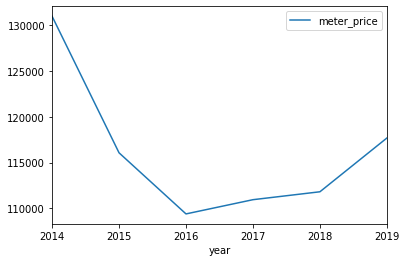

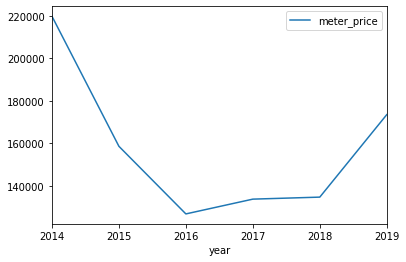

In [35]:
#дата размещения объявления
pd.pivot_table(data =peterdf , index = 'year', values = 'meter_price', aggfunc = 'mean' ).plot()
pd.pivot_table(data = peterdfcenter, index = 'year', values = 'meter_price', aggfunc = 'mean' ).plot()

#цены в центре и во всем горде колеблятся в целом одинаково 

### Шаг 5. Общий вывод

Мы изучили предоставленные данные. Удалили пропуски и дополнили информацию различными способами там где это было возможно, изменили формат на подходящий. Дополнили таблицу индексами насленных пунктов, нашли стоимость квадратного метра, соотношение общей плоащади к жилой и площади кухни, нашли тип этажа где размещена квартира.
Построили гистаграммы для площади, цены, количества комнат и высоты потолков. Убрали выделяющиеся значения, где это было необходимо приведя гистграммы к нормальному распредленеию и распределению Пуассона. 
Изучили время продажи квартиры, выяснили что необычно долго - когда квартиру не покупают более 500 дней, в среднем продажа занимает около 180 дней. (номрально от 50 до 220 дней), но если очень повезет или сильно занизить цену то можно продать менее чем за  50дней. Изучили зависимость стоимости квартиры от центра города, типа этажа, даты публикации. Рассмотрели как с годами менялась средняя стоимость недвижимости в городе.
Выделили 10 самых крупных городов в базе и посчитали среднюю стоимость жилья в каждом из них, выявив что самое дорогое жилье в Петербурге и Пушкине, а самое дешевое во Всеволожске и Гатчине. 
Наконец выделили центральный сегмент квартир в Петербурге радиусом 3км от центра. Выяснили что он отличается от остального города стоимостью жилья, высотой потолков, а еще последние этажы в здесь не так ценны как на окраине. Квартиры тут на 30% больше и почти вдвое дороже. Вместе с этим данный сегмент так же подвержен рыночным колебаниям как и стоимость квартир во всем городе.
